In [76]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display  import Audio
from sklearn import preprocessing
import seaborn as sns
import missingno as msno

In [77]:
def normalize(x, axis = 0):
    return preprocessing.minmax_scale(x, axis = axis)
def extrae_var(cancion):
    cancion = cancion
    samples, sr = librosa.load(cancion, sr = None, mono = True, offset = 0.0, duration = 60)
    

    X = librosa.stft(samples)
    Xdb = librosa.amplitude_to_db(abs(X))

    zero_crossings= librosa.zero_crossings(samples, pad=False)
    zero_c = np.mean(zero_crossings)

    spectral_centroids = librosa.feature.spectral_centroid(y=samples, sr=sr)[0]
    spectral_centroids.shape
    spec_centroid = np.mean(spectral_centroids)

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    spr = librosa.feature.spectral_rolloff(y=samples + 0.01, sr=sr)[0]
    spec_rollof = np.mean(spr)

    mfccs = librosa.feature.mfcc(y = samples, sr = sr)

    salto = 512
    cromatica = librosa.feature.chroma_stft(y=samples, sr=sr, hop_length=salto)
    croma = np.mean(cromatica)

    hop_length = 512
    env = librosa.onset.onset_strength(y = samples, sr = sr, hop_length = hop_length)
    tempograma = librosa.feature.tempogram(onset_envelope = env, sr = sr, hop_length = hop_length)

    #el onset envelope resalta los momentos 
    #en los que comienzan las notas, golpes u 
    #otros eventos importantes en la música

    auto_c = librosa.autocorrelate(env, max_size = tempograma.shape[0])
    auto_c = librosa.util.normalize(auto_c)
    autocorr = np.mean(auto_c)
    #mostrar los "beats"
    tempo = librosa.beat.tempo(onset_envelope = env, sr = sr, hop_length = hop_length)[0]

    FRAME_LENGTH = 1024
    HOP_LENGTH = 512

    rms = librosa.feature.rms(y=samples, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    rms=np.mean(rms)# aquí he metido el rms y de todos los valores he usado la media al igual que el resto, pero sin criterio alguno la verdad

    columnas = ['archivo', 'zero_cr', 'spectral_centroid', 'spectral_rf', 'croma', 'BPM', 'auto_c','rms']
    for x in range(1, 21):
        columnas.append(f'mfcc_{x}')

    df = pd.DataFrame(columns=columnas)

    #Fila de datos
    x = [cancion, zero_c,spec_centroid,spec_rollof, croma, tempo, autocorr,rms]
    x.extend([np.mean(m) for m in mfccs])
    df.loc[len(df)] = x
    return df
    

In [79]:
# Al restructurar las carpetas hay que hacer un script que lea los archivos de cada carpeta

df_t=pd.DataFrame()
for subcarpeta in os.listdir('data'):
    for archivo in os.listdir('data/'+subcarpeta):
        if archivo.endswith('.mp3'):
            cancion='data/'+subcarpeta +'/'+archivo
            df=extrae_var(cancion)
            df_t=pd.concat([df_t,df])
df_t.reset_index(drop=True,inplace=True)

C:\Users\lmrio\AppData\Local\Temp\ipykernel_12204\657141990.py:42: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope = env, sr = sr, hop_length = hop_length)[0]
C:\Users\lmrio\AppData\Local\Temp\ipykernel_12204\657141990.py:42: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope = env, sr = sr, hop_length = hop_length)[0]
C:\Users\lmrio\AppData\Local\Temp\ipykernel_12204\657141990.py:42: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope = env, sr = sr, hop_length = hop_length)[0]
C:\Users\lmrio\AppD

In [80]:
# se elimina la variable archivo para el cluster y escalado de datos OJO LOS RESULTADOS VARIAN MUCHO SI SE ESCALAN LOS DATOS O NO
# HABRÄ QUE ESTUDIARLO BIEN.
train=df_t.drop('archivo', axis=1).copy()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_scaled=scaler.fit_transform(train)
train_scaled=pd.DataFrame(train_scaled, columns=train.columns.to_list())

In [94]:
train_scaled.std()

zero_cr              1.118034
spectral_centroid    1.118034
spectral_rf          1.118034
croma                1.118034
BPM                  1.118034
auto_c               1.118034
rms                  1.118034
mfcc_1               1.118034
mfcc_2               1.118034
mfcc_3               1.118034
mfcc_4               1.118034
mfcc_5               1.118034
mfcc_6               1.118034
mfcc_7               1.118034
mfcc_8               1.118034
mfcc_9               1.118034
mfcc_10              1.118034
mfcc_11              1.118034
mfcc_12              1.118034
mfcc_13              1.118034
mfcc_14              1.118034
mfcc_15              1.118034
mfcc_16              1.118034
mfcc_17              1.118034
mfcc_18              1.118034
mfcc_19              1.118034
mfcc_20              1.118034
dtype: float64

In [82]:
# pca para representación solo, habría que analizar la varianza que explica si queremos usarla realmente 
# y comprobar con el AIC y BIC del modelo final para tomar una decisión.
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x=pca.fit_transform(train_scaled)
df_pca=pd.DataFrame(x,columns=['a','b'])

In [83]:
# función para el metodo del codo y ver numero de clusters recomendados.

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def elbow_method(data, max_clusters=5):
    sum_of_squared_distances = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)
    # Graficar la curva del codo
    plt.plot(range(1, max_clusters+1), sum_of_squared_distances, 'bx-')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Suma de las Distancias al Cuadrado')
    plt.title('Curva del Codo')
    plt.show()

c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

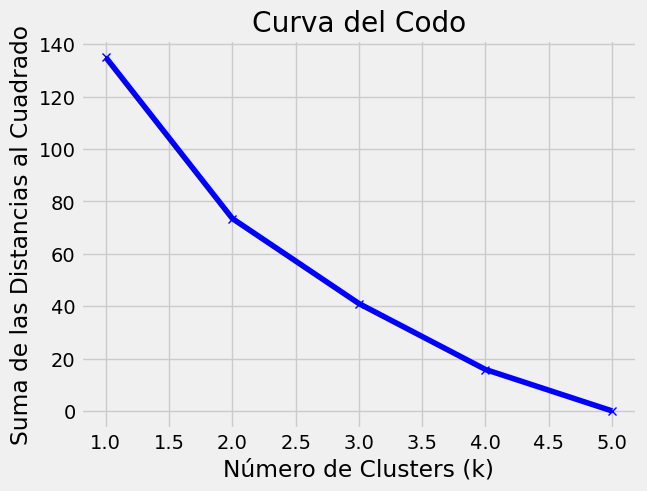

In [84]:
elbow_method(train_scaled)


c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

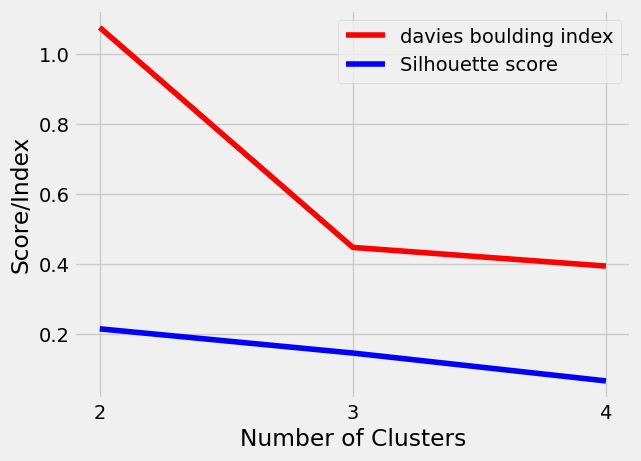

In [85]:
#script para representar coeficiente de silueta y de davies para ver numero de clusters
from sklearn.metrics import davies_bouldin_score, silhouette_score
 

silhouette_coefficients = []
davies_bouldin_scores = []
# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train_scaled)
    sil_score = silhouette_score(train_scaled, kmeans.labels_)
    silhouette_coefficients.append(sil_score)
    db_score = davies_bouldin_score(train_scaled, kmeans.labels_)
    davies_bouldin_scores.append(db_score)
 

plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), davies_bouldin_scores, color='red', label = 'davies boulding index')
plt.plot(range(2, 5), silhouette_coefficients, color='blue', label = 'Silhouette score')
plt.xticks(range(2, 5))

plt.xlabel("Number of Clusters")
plt.ylabel("Score/Index")
plt.legend()
plt.show()

In [86]:

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(train_scaled)

df_t['Target']=kmeans.labels_
df_pca['Target']=kmeans.labels_

c:\Users\lmrio\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<BarContainer object of 27 artists>

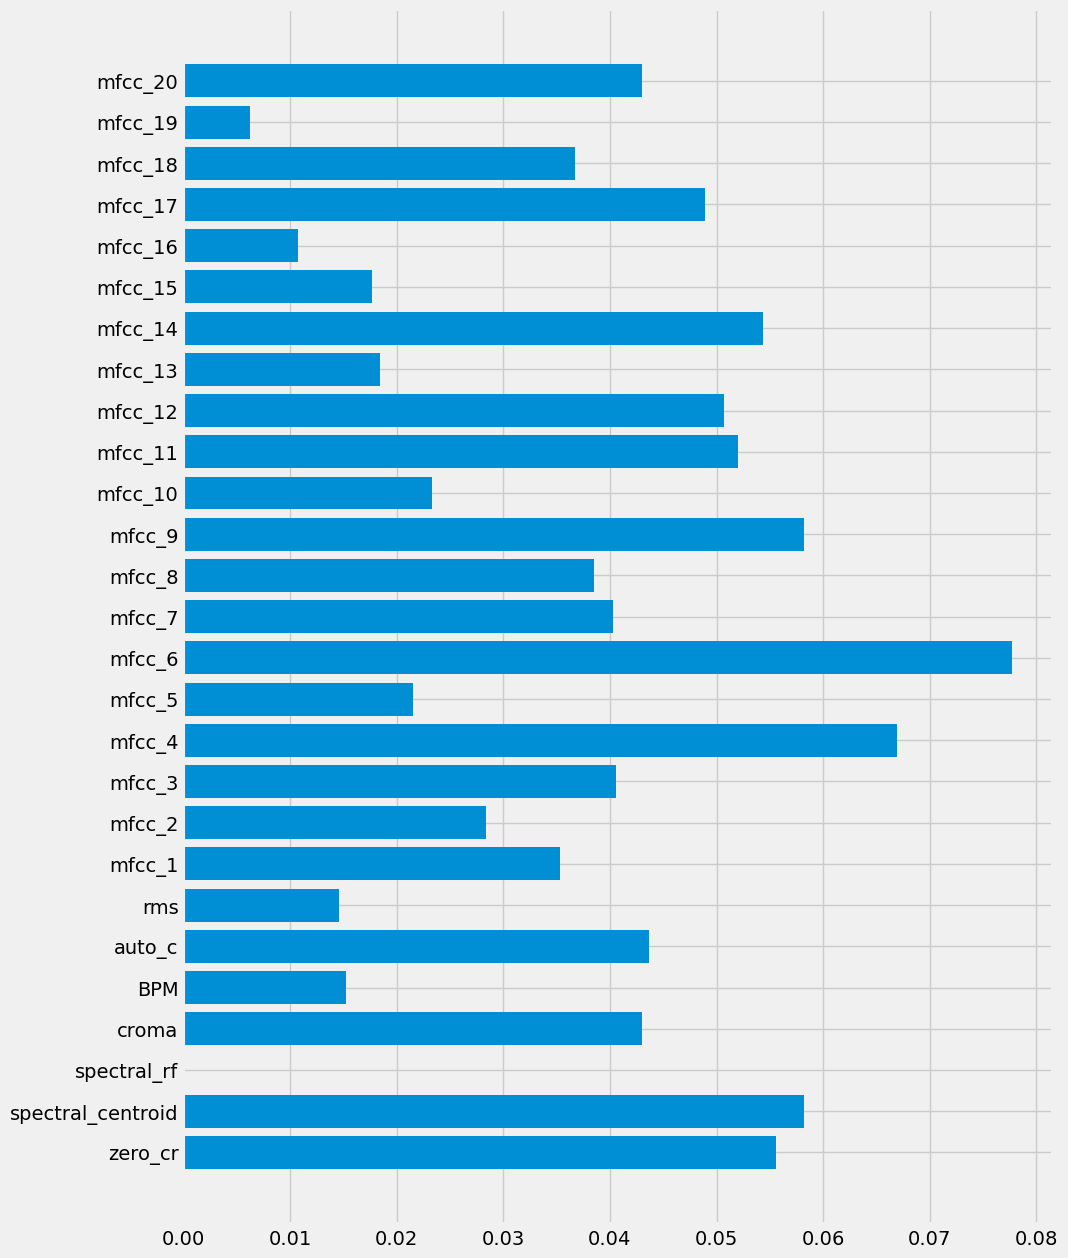

In [87]:
#importancia de las variables si usasemos un Clasificador de Arbol de decisión.
from sklearn.ensemble import RandomForestClassifier
reg=RandomForestClassifier()
reg.fit(X = train_scaled, y = kmeans.labels_)
plt.figure(figsize = (10,15))
plt.barh(reg.feature_names_in_,reg.feature_importances_)

<Axes: xlabel='a', ylabel='b'>

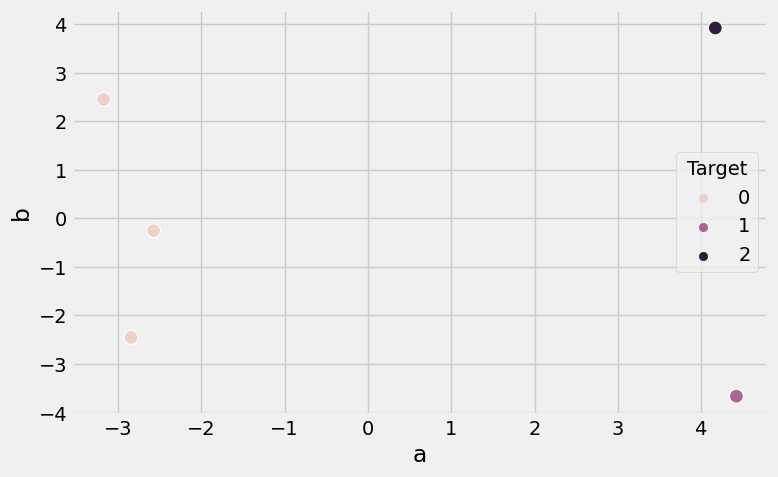

In [88]:
#representación perra final
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_pca, x='a', y='b', hue='Target', s =100)
